In [2]:
from google.colab import files
uploaded = files.upload()


Saving shopee_reviews.csv to shopee_reviews.csv


In [3]:
import pandas as pd

df = pd.read_csv("shopee_reviews.csv")
df.head()


/tmp/ipython-input-2461123766.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("shopee_reviews.csv")


,label,text
0,5,Looks ok. Not like so durable. Will hv to use ...
1,5,"Tried, the current can be very powerful depend..."
2,5,Item received after a week. Looks smaller than...
3,5,Thanks!!! Works as describe no complaints. Not...
4,5,Fast delivery considering it’s from overseas a...


In [4]:
def map_label_to_sentiment(r):
    if r in [4, 5]:
        return "positive"
    elif r == 3:
        return "neutral"
    else:
        return "negative"

df["sentiment_true"] = df["label"].apply(map_label_to_sentiment)
df[["label", "sentiment_true", "text"]].head(10)


,label,sentiment_true,text
0,5,positive,Looks ok. Not like so durable. Will hv to use ...
1,5,positive,"Tried, the current can be very powerful depend..."
2,5,positive,Item received after a week. Looks smaller than...
3,5,positive,Thanks!!! Works as describe no complaints. Not...
4,5,positive,Fast delivery considering it’s from overseas a...
5,5,positive,Fast delivery good service
6,5,positive,Got my order and it came well packaged. Have y...
7,5,positive,Items received in a nice box. Have not used it...
8,5,positive,"Received in good condition, tried so far so go..."
9,1,negative,Item doesn’t work . \n\nAsked me to send a ref...


In [5]:
!pip install replicate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 2.0 MB/s eta 0:00:00


In [6]:
import os, getpass

if "REPLICATE_API_TOKEN" not in os.environ:
    os.environ["REPLICATE_API_TOKEN"] = getpass.getpass("Masukkan REPLICATE_API_TOKEN: ")

print("✅ Replicate token sudah tersimpan")


Masukkan REPLICATE_API_TOKEN: ··········
✅ Replicate token sudah tersimpan


In [8]:
import replicate

# Slug model Granite (cek halaman model di Replicate, contoh ini pakai Granite Instruct 13B)
MODEL_SLUG = "ibm/ibm-granite-13b-instruct"

def granite_infer(prompt, max_tokens=200, temperature=0.2):
    output = replicate.run(
        MODEL_SLUG,
        input={
            "prompt": prompt,
            "max_new_tokens": max_tokens,
            "temperature": temperature
        }
    )
    if isinstance(output, (list, tuple)):
        return "".join([str(t) for t in output])
    return str(output)


In [9]:
FEW_SHOT_SHOPEE = '''
You are a helpful assistant. Classify the sentiment of the following Shopee product review
into one of: positive, neutral, negative.
Return ONLY the label.

Example:
Review: "Barangnya bagus, sesuai deskripsi, pengiriman cepat"
Label: positive

Example:
Review: "Biasa saja, tidak terlalu bagus, tapi juga tidak jelek"
Label: neutral

Example:
Review: "Packing rusak, barang cacat, sangat mengecewakan"
Label: negative
'''

def granite_classify_review(text):
    prompt = FEW_SHOT_SHOPEE + f"\n\nReview: \"{text}\"\nLabel:"
    out = granite_infer(prompt, max_tokens=10, temperature=0.0)
    return out.strip().split()[0].lower()


In [10]:
sample_df = df.sample(50, random_state=42).copy()
sample_df["sentiment_pred"] = sample_df["text"].apply(granite_classify_review)
sample_df[["text", "sentiment_true", "sentiment_pred"]].head(10)


ReplicateError: ReplicateError Details:
status: 404
detail: The requested resource could not be found.

In [11]:
!pip install replicate

import os, getpass, replicate

# Masukkan API token Replicate kamu
if "REPLICATE_API_TOKEN" not in os.environ:
    os.environ["REPLICATE_API_TOKEN"] = getpass.getpass("Masukkan REPLICATE_API_TOKEN: ")

print("✅ Token sudah diset")

# Pakai slug terbaru dari Replicate
MODEL_SLUG = "ibm-granite/granite-3.3-8b-instruct"

def granite_infer(prompt, max_tokens=200, temperature=0.2):
    output = replicate.run(
        MODEL_SLUG,
        input={
            "prompt": prompt,
            "max_new_tokens": max_tokens,
            "temperature": temperature
        }
    )
    if isinstance(output, (list, tuple)):
        return "".join([str(t) for t in output])
    return str(output)


✅ Token sudah diset


In [12]:
FEW_SHOT_SHOPEE = '''
You are a helpful assistant. Classify the sentiment of the following Shopee product review
into one of: positive, neutral, negative.
Return ONLY the label.

Example:
Review: "Barangnya bagus, sesuai deskripsi, pengiriman cepat"
Label: positive

Example:
Review: "Biasa saja, tidak terlalu bagus, tapi juga tidak jelek"
Label: neutral

Example:
Review: "Packing rusak, barang cacat, sangat mengecewakan"
Label: negative
'''

def granite_classify_review(text):
    prompt = FEW_SHOT_SHOPEE + f"\n\nReview: \"{text}\"\nLabel:"
    out = granite_infer(prompt, max_tokens=10, temperature=0.0)
    return out.strip().split()[0].lower()


In [13]:
sample_df = df.sample(20, random_state=42).copy()  # ambil 20 dulu biar cepat
sample_df["sentiment_pred"] = sample_df["text"].apply(granite_classify_review)

sample_df[["text", "sentiment_true", "sentiment_pred"]].head(10)


,text,sentiment_true,sentiment_pred
1121587,Love these masks and samples given. Will try o...,positive,positive
1104606,Good value for 300g tube. Thank you !,positive,positive
339262,amazing!!!,positive,positive
1382344,Ordered a Size 12 but came a Size 9 so I’m not...,negative,neutral
1355964,Ordered on 3/11/19 received item in good condi...,negative,positive
665252,Super comfy.....love it.....,positive,positive
8125,Item was in great condition. Super fast delive...,positive,positive
82967,Good fast and efficient.. recommended.,positive,positive
604161,difficult to apply on phone due to many air bu...,positive,neutral
1454651,"It’s not a silent keyboard, the letter “T” is ...",negative,negative


In [14]:
accuracy = (sample_df["sentiment_true"] == sample_df["sentiment_pred"]).mean()
print(f"Akurasi Granite vs rating bintang: {accuracy:.2f}")


Akurasi Granite vs rating bintang: 0.65


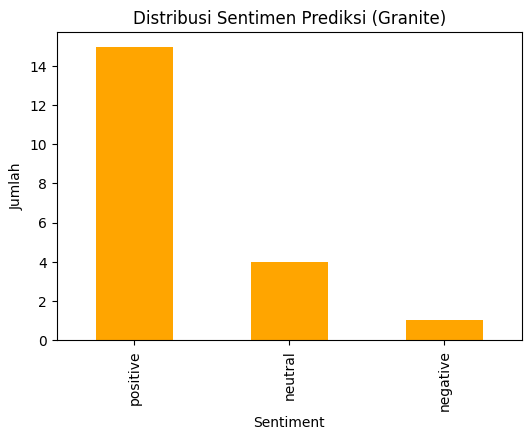

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sample_df["sentiment_pred"].value_counts().plot(kind="bar", color="orange")
plt.title("Distribusi Sentimen Prediksi (Granite)")
plt.xlabel("Sentiment")
plt.ylabel("Jumlah")
plt.show()


In [16]:
subset_reviews = " \n".join(df["text"].dropna().astype(str).head(50).tolist())
SUM_PROMPT = f"""
Summarize the following Shopee reviews in Indonesian.
Group insights into: product quality, shipping, packaging, and price.
Limit to 5 bullet points.

Reviews:
{subset_reviews}
"""

summary = granite_infer(SUM_PROMPT, max_tokens=300, temperature=0.2)
print("🔹 Ringkasan Insight dari Shopee Reviews:\n", summary)


🔹 Ringkasan Insight dari Shopee Reviews:
 **Kualitas Produk:**
- Beberapa pembeli mengatakan produk bekerja sesuai dengan deskripsi, tetapi beberapa mengatakan kualitas fisik tidak sejajar dengan harapan.
- Pembeli yang sudah menggunakannya mengatakan dapat merasakan kesan pada otot, tetapi beberapa merasa perlu waktu untuk mengetahui kinerja lama.
- Ada pembeli yang mengatakan produk tidak bekerja secara total, dan diharuskan untuk mendapatkan pengembalian.

**Pengiriman:**
- Pembeli mengatakan pengiriman cepat, terutama untuk produk dari luar negeri.
- Ada beberapa kasus pengiriman yang tepat waktu, tetapi ada juga yang mencatat waktu pengiriman lebih lama daripada yang diharapkan.

**Pakaging:**
- Pembeli mengatakan pakaging baik, dengan beberapa yang menerima produk dalam kondisi baik meski ada kerusakan di lapisan luar.
- Ada juga yang terima produk dengan manual dan tas air, menunjukkan bahwa produk dihantar komplet.

**Harga:**
- Pembeli mengatakan harga yang terjangkau, dengan 